In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

### Load data from file

In [2]:
dir = 'AAPL.json'

In [3]:
if os.path.exists(dir):
    with open(dir) as f:
        df = pd.read_json(dir)
else:
    raise SystemExit("File not found!")

In [4]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1980-12-12 05:00:00,0.099584,0.100017,0.099584,0.099584,469033600,0.0,0
1980-12-15 05:00:00,0.094821,0.094821,0.094388,0.094388,175884800,0.0,0
1980-12-16 05:00:00,0.087893,0.087893,0.087461,0.087461,105728000,0.0,0
1980-12-17 05:00:00,0.089625,0.090058,0.089625,0.089625,86441600,0.0,0
1980-12-18 05:00:00,0.092224,0.092657,0.092224,0.092224,73449600,0.0,0


### Add Target
> Assign a value of 1 if the price is expected to increase tomorrow, or 0 if it is not.

In [5]:
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [6]:
X = df.drop('Target', axis=1)
y = df['Target']

In [7]:
y.value_counts()

0    5386
1    5319
Name: Target, dtype: int64

### Create backtest function
> Create backtest function to more accurately test the model on time series data.

In [8]:
from IPython.display import clear_output
def backtest(model, X, y, init=1000, test=365, selector=None):
# def backtest(model, X, y, init=2000, test=500, selector=None):
    preds = pd.DataFrame()
    for i in range(init, len(X), test):
        X_train, X_test = X[:i], X[i:i+test]
        y_train, y_test = y[:i], y[i:i+test]
        # X_train, X_test = X[i-init:i], X[i:i+test]
        # y_train, y_test = y[i-init:i], y[i:i+test]
        close = X_test['Close'].copy()

        if selector is not None:
            selector.fit(X_train, y_train)
            selected = selector.get_support()
            X_train, X_test = X_train.iloc[:, selected], X_test.iloc[:, selected]

        model.fit(X_train, y_train)

        temp = pd.concat([
            close,
            y_test,
            pd.DataFrame(model.predict(X_test), columns=['y_pred'], index=y_test.index),
            pd.DataFrame(model.predict_proba(X_test)[:,1], columns=['y_prob'], index=y_test.index)
        ], axis=1)
        preds = pd.concat([preds, temp], axis=0)

        # Progress bar. Because this takes a while...
        clear_output(wait=False)
        print(f"[{'█'*int(i/(len(X))*50)}{' '*(50-int(i/(len(X))*50))}] {i}/{len(X)}")
    return preds

### First model fit on raw data

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)

In [10]:
from sklearn.metrics import classification_report
results_origin = backtest(clf, X, y)
print(classification_report(results_origin['Target'], results_origin['y_pred']))

[████████████████████████████████████████████████  ] 10490/10705
              precision    recall  f1-score   support

           0       0.50      0.68      0.58      4836
           1       0.51      0.33      0.40      4869

    accuracy                           0.51      9705
   macro avg       0.51      0.51      0.49      9705
weighted avg       0.51      0.51      0.49      9705



### Add features

In [11]:
# Ratios
df['High/Close'] = df['High'] / df['Close']
df['Low/Close'] = df['Low'] / df['Close']
df['Open/Close'] = df['Open'] / df['Close']
df['High/Low'] = df['High'] / df['Low']

In [12]:
# Last dividend amount
df['Last Dividend'] = df['Dividends']
df.loc[df['Last Dividend'] == 0, 'Last Dividend'] = None
df['Last Dividend'] = df['Last Dividend'].ffill()

In [13]:
def days_since(df, col, new_col):
    df[new_col] = float('nan')
    days_counter = 0
    split_occurred = False

    for i, row in df.iterrows():
        split_value = row[col]
        if split_value > 0:
            if not split_occurred:
                split_occurred = True
            days_counter = 0
        else:
            if split_occurred:
                days_counter += 1
        if split_occurred:
            df.at[i, new_col] = days_counter
    return df

In [14]:
# Days since dividend payment or stock split
df = days_since(df, 'Dividends', 'Days Since Dividend')
df = days_since(df, 'Stock Splits', 'Days Since Split')

In [15]:
# Rolling average, standard deviation
rolling_window = [7, 20, 90, 365]
for window in rolling_window:
    df[f'SMA_{window}'] = df['Close'].rolling(window).mean()
    df[f'STD_{window}'] = df['Close'].rolling(window).std()

# Ratios of SMAs
df['365/90'] = df['SMA_365'] / df['SMA_90']
df['365/20'] = df['SMA_365'] / df['SMA_20']
df['365/7'] = df['SMA_365'] / df['SMA_7']

In [16]:
# Bollinger Bands
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

# Relative Strength Index (RSI)
delta = df['Close'].diff()
SMA_U = delta.where(delta > 0, 0).rolling(14).mean()
SMA_D = -delta.where(delta < 0, 0).rolling(14).mean()
df['RSI'] = 100 - (100 / (1 + SMA_U / SMA_D))

# MACD
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()

In [17]:
df['Trend'] = df.shift(1).rolling(7).sum()['Target']

In [18]:
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target,High/Close,Low/Close,...,STD_365,365/90,365/20,365/7,Upper_Band,Lower_Band,RSI,MACD,MACD_Signal,Trend
1987-06-16 04:00:00,0.287932,0.289667,0.263649,0.287932,342720000,0.0,2,0,1.006024,0.915663,...,0.060710,0.608166,0.555224,0.545601,0.285623,0.254206,65.217131,0.003958,0.003300,3.0
1987-06-17 04:00:00,0.287932,0.294870,0.277525,0.280994,297920000,0.0,0,1,1.049382,0.987655,...,0.060985,0.607830,0.554506,0.544416,0.285832,0.256685,53.845773,0.004219,0.003483,3.0
1987-06-18 04:00:00,0.279260,0.289667,0.274056,0.287932,229600000,0.0,0,0,1.006024,0.951808,...,0.061293,0.607260,0.553605,0.542110,0.287806,0.257660,64.284921,0.004928,0.003772,3.0
1987-06-19 04:00:00,0.287932,0.289667,0.280127,0.284463,125440000,0.0,0,1,1.018294,0.984757,...,0.061571,0.606772,0.553037,0.540769,0.288389,0.259680,65.453449,0.005150,0.004048,3.0
1987-06-22 04:00:00,0.286198,0.293136,0.283596,0.291401,169120000,0.0,0,0,1.005952,0.973213,...,0.061886,0.606522,0.551714,0.538090,0.289788,0.261706,72.129772,0.005820,0.004402,3.0


In [19]:
X = df.drop('Target', axis=1)
y = df['Target']

In [20]:
y.value_counts()

1    4565
0    4496
Name: Target, dtype: int64

### Model fit on augmented data

In [21]:
# Feature selection
from sklearn.feature_selection import SequentialFeatureSelector
selector = SequentialFeatureSelector(clf, n_features_to_select='auto', n_jobs=-1)

In [22]:
results = backtest(clf, X, y, selector=selector)
print(classification_report(results['Target'], results['y_pred']))

[█████████████████████████████████████████████████ ] 9030/9061
              precision    recall  f1-score   support

           0       0.50      0.58      0.53      3972
           1       0.51      0.43      0.47      4089

    accuracy                           0.50      8061
   macro avg       0.50      0.50      0.50      8061
weighted avg       0.50      0.50      0.50      8061



### Plot cumulative returns

In [35]:
# Calculate returns for augmented data
results['Return'] = np.log(results['Close'].shift(-1) / results['Close'])
results['Strat Return'] = results['y_pred'] * results['Return']
results = results.dropna()

In [36]:
# Calculate returns for original data
results_origin['Return'] = np.log(results_origin['Close'].shift(-1) / results_origin
['Close'])
results_origin = results_origin[results.index[0]:]
results_origin['Strat Return'] = results_origin['y_pred'] * results_origin['Return']
results_origin = results_origin.dropna()

In [37]:
# Calculate cumulative returns
results['Cum Strat'] = np.cumsum(results['Strat Return'])
results_origin['Cum Strat'] = np.cumsum(results_origin['Strat Return'])

In [38]:
results.head()

,Close,Target,y_pred,y_prob,Return,Strat Return,Cum Market,Cum Strat
1991-05-30 04:00:00,0.343469,0,0,0.390088,-0.013209,-0.0,-0.013209,-0.0
1991-05-31 04:00:00,0.338962,1,0,0.285926,0.046761,0.0,0.033552,0.0
1991-06-03 04:00:00,0.355189,0,0,0.413151,-0.002541,-0.0,0.031011,0.0
1991-06-04 04:00:00,0.354287,0,0,0.406167,-0.023168,-0.0,0.007843,0.0
1991-06-05 04:00:00,0.346174,0,0,0.495787,-0.029063,-0.0,-0.021220,0.0


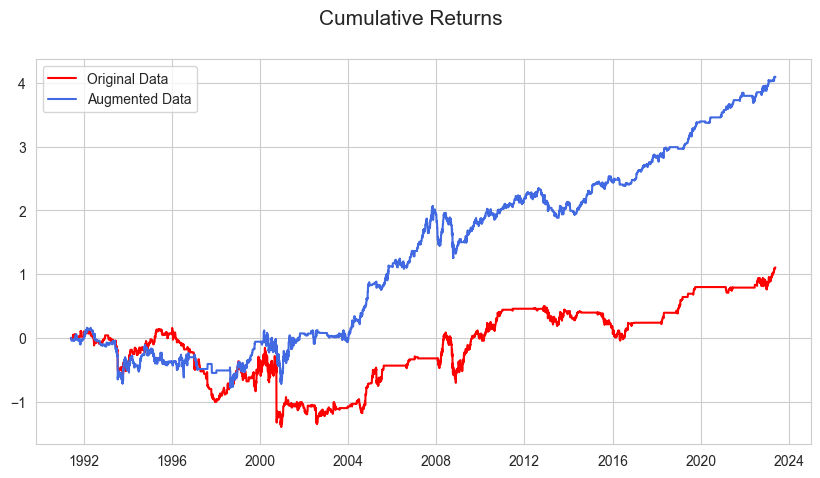

In [39]:
plt.figure(figsize=(10, 5))
plt.suptitle('Cumulative Returns', fontsize=15)
plt.plot(results_origin['Cum Strat'], color='red', label='Original Data')
plt.plot(results['Cum Strat'], color='royalblue', label='Augmented Data')
plt.legend()
plt.show()

### Additional statistics

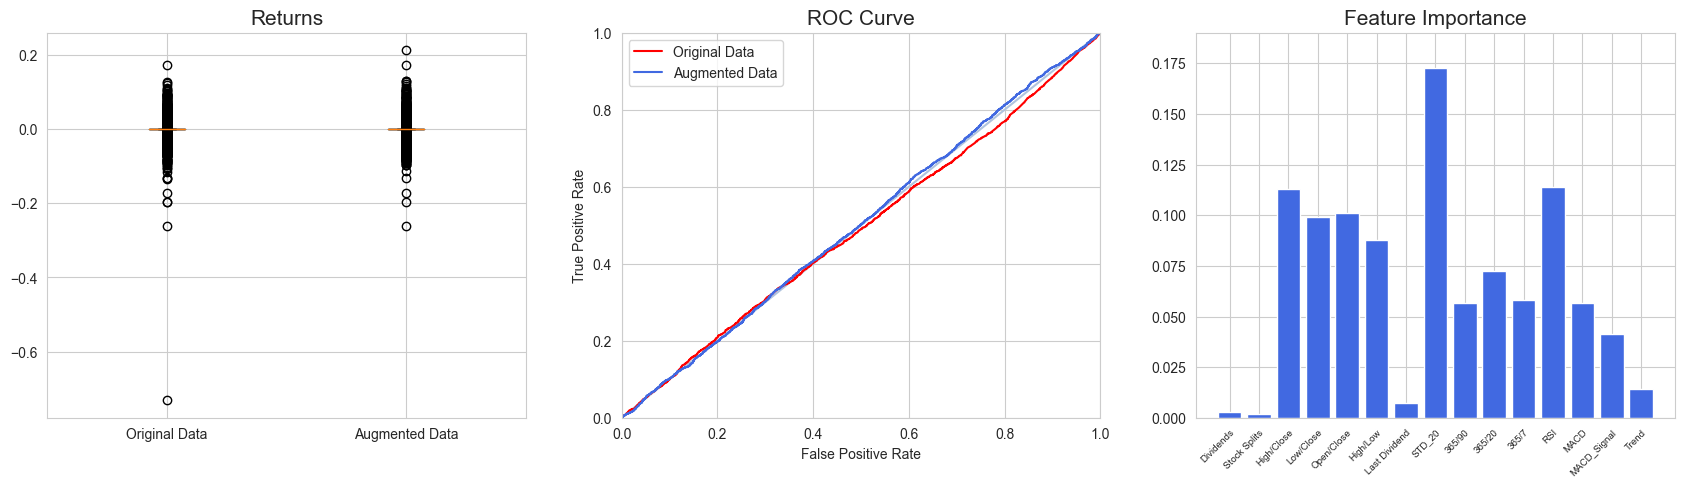

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# Box plot
axes[0].boxplot([results_origin['Strat Return'], results['Strat Return']])
axes[0].set_xticks([1, 2], ['Original Data', 'Augmented Data'])
axes[0].set_title('Returns', fontsize=15)

# ROC Curve
fpr0, tpr0, _ = roc_curve(results_origin['Target'], results_origin['y_prob'])
fpr1, tpr1, _ = roc_curve(results['Target'], results['y_prob'])

axes[1].plot([0, 1], [0, 1], color='lightsteelblue') # Reference line
axes[1].plot(fpr0, tpr0, color='red', label='Original Data')
axes[1].plot(fpr1, tpr1, color='royalblue', label='Augmented Data')
axes[1].set_title('ROC Curve', fontsize=15)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].legend()

# Feature Importance
axes[2].bar(clf.feature_names_in_, clf.feature_importances_, color='royalblue')
axes[2].set_title('Feature Importance', fontsize=15)
axes[2].set_ylim([0, max(clf.feature_importances_) * 1.1])
axes[2].set_xticks(clf.feature_names_in_)
axes[2].set_xticklabels(clf.feature_names_in_, rotation=45, rotation_mode='anchor', ha='right', fontsize=7)

plt.show()